# Model Comparison Lab

In this lab we will compare the performance of all the models we have learned about so far, using the car evaluation dataset.

## 1. Prepare the data

The [car evaluation dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/car/) is in the assets/datasets folder. By now you should be very familiar with this dataset.

1. Load the data into a pandas dataframe
- Encode the categorical features properly: define a map that preserves the scale (assigning smaller numbers to words indicating smaller quantities)
- Separate features from target into X and y

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('../../assets/datasets/car.csv')

#use value counts of column to create map
mappy = {
    'low' : 1,
    'small': 1,
    'med' : 2,
    'high': 3,
    'big' : 3,
    'vhigh': 4,
    'unacc': 1,
    'acc': 2,
    'good': 3,
    'vgood': 4,
    '2': 2,
    '3': 3,
    '4': 4,
    '5more': 5,
    'more': 6,
}



In [3]:
df = data.applymap(lambda x : mappy[x])
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,4,4,2,2,1,1,1
1,4,4,2,2,1,2,1
2,4,4,2,2,1,3,1
3,4,4,2,2,2,1,1
4,4,4,2,2,2,2,1


In [4]:
X = df.drop('acceptability',axis = 1)
y = df['acceptability']

## 2. Useful preparation

Since we will compare several models, let's write a couple of helper functions.

1. Separate X and y between a train and test set, using 30% test set, random state = 42
    - make sure that the data is shuffled and stratified
2. Define a function called `evaluate_model`, that trains the model on the train set, tests it on the test, calculates:
    - accuracy score
    - confusion matrix
    - classification report
3. Initialize a global dictionary to store the various models for later retrieval


In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cross_validation import KFold

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

all_models = {}

def evaluate_model(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred,y_test)
    print "SCORE: %s" % score
    #print "Score: %s" % model.score(y_test,y_pred)
    print "<------------------------------------------->"
    cnf = confusion_matrix(y_test, y_pred)
    print "CONFUSION MATRIX"
    print pd.DataFrame(cnf, columns = ['pred_unacc', 'pred_acc', 'pred_good', 'pred_vgood'], 
                       index = ['unacc', 'acc', 'good', 'vgood'])
    print "<------------------------------------------->"
    print classification_report(y_test, y_pred, target_names = ['unacc', 'acc', 'good', 'vgood'])
    return score
    
def gridder(model, params):
    gs = GridSearchCV(model,
                     params,
                     cv=KFold(len(y), shuffle=True))
    gs.fit(X,y)
    print "Best params: %s" % gs.best_params_
    print "Best score: %s" % gs.best_score_
    return gs

/Users/jroyalty/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 3.a KNN

Let's start with `KNeighborsClassifier`.

1. Initialize a KNN model
- Evaluate it's performance with the function you previously defined
- Find the optimal value of K using grid search
    - Be careful on how you perform the cross validation in the grid search

In [6]:
from sklearn.neighbors import KNeighborsClassifier    

all_models['knn'] = {'model': KNeighborsClassifier(),
                    'score': evaluate_model(KNeighborsClassifier())}
param_grid = {
    'n_neighbors': range(1,10),
}

print "KNN GRIDSEARCH"
gs_knn = gridder(KNeighborsClassifier(), param_grid)

all_models['gs_knn'] = {'model': gs_knn.best_estimator_,
                    'score': evaluate_model(gs_knn.best_estimator_)}



SCORE: 0.938342967245
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         357         6          0           0
acc             8       106          1           0
good            1        11          9           0
vgood           0         4          1          15
<------------------------------------------->
             precision    recall  f1-score   support

      unacc       0.98      0.98      0.98       363
        acc       0.83      0.92      0.88       115
       good       0.82      0.43      0.56        21
      vgood       1.00      0.75      0.86        20

avg / total       0.94      0.94      0.93       519

KNN GRIDSEARCH
Best params: {'n_neighbors': 5}
Best score: 0.929398148148
SCORE: 0.938342967245
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         357         6          0           0
acc             8       106     

## 3.b Bagging + KNN

Now that we have found the optimal K, let's wrap `KNeighborsClassifier` in a BaggingClassifier and see if the score improves.

1. Wrap the KNN model in a Bagging Classifier
- Evaluate performance
- Do a grid search only on the bagging classifier params

In [7]:
from sklearn.ensemble import BaggingClassifier

bag_knn = BaggingClassifier(KNeighborsClassifier())

# evaluate_model(bag_knn)
all_models['knn_bagging'] = {'model': bag_knn,
                    'score': evaluate_model(bag_knn)}

param_grid = {
    'n_estimators': [10, 20],
    'max_samples': [0.7, 1.0],
    'bootstrap_features': [True, False]
             }

print "Bagging + KNN + GRIDSEARCH"
gs_bag_knn = gridder(bag_knn, param_grid)

all_models['gs_knn_bagging'] = {'model': gs_bag_knn.best_estimator_,
                    'score': evaluate_model(gs_bag_knn.best_estimator_)}

SCORE: 0.93063583815
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         356         7          0           0
acc            11       101          3           0
good            0         9         12           0
vgood           0         6          0          14
<------------------------------------------->
             precision    recall  f1-score   support

      unacc       0.97      0.98      0.98       363
        acc       0.82      0.88      0.85       115
       good       0.80      0.57      0.67        21
      vgood       1.00      0.70      0.82        20

avg / total       0.93      0.93      0.93       519

Bagging + KNN + GRIDSEARCH
Best params: {'n_estimators': 20, 'max_samples': 1.0, 'bootstrap_features': False}
Best score: 0.9375
SCORE: 0.938342967245
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         356         7  

## 4. Logistic Regression

Let's see if logistic regression performs better

1. Initialize LR and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [8]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

all_models['logit'] = {'model': logit,
                    'score': evaluate_model(logit)}

param_grid = {
    'penalty': ['l1','l2'],
    'C': [.001, .01, .1, 1, 100],
}

print "Logit + GRIDSEARCH"
gs_logit = gridder(logit, param_grid)

all_models['gs_logit'] = {'model': gs_logit.best_estimator_,
                    'score': evaluate_model(gs_logit.best_estimator_)}


SCORE: 0.763005780347
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         346        11          4           2
acc            65        48          2           0
good            6        13          1           1
vgood           0        19          0           1
<------------------------------------------->
             precision    recall  f1-score   support

      unacc       0.83      0.95      0.89       363
        acc       0.53      0.42      0.47       115
       good       0.14      0.05      0.07        21
      vgood       0.25      0.05      0.08        20

avg / total       0.71      0.76      0.73       519

Logit + GRIDSEARCH
Best params: {'penalty': 'l1', 'C': 100}
Best score: 0.814814814815
SCORE: 0.791907514451
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         344        14          3           2
acc            58  

## 5. Decision Trees

Let's see if Decision Trees perform better

1. Initialize DT and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

all_models['logit'] = {'model': dt,
                    'score': evaluate_model(dt)}

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3]
}

print "Decision tree + GRIDSEARCH"
gs_dt = gridder(dt, param_grid)

all_models['gs_dt'] = {'model': gs_dt.best_estimator_,
                    'score': evaluate_model(gs_dt.best_estimator_)}


SCORE: 0.963391136802
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         361         2          0           0
acc             9       104          2           0
good            1         4         16           0
vgood           0         1          0          19
<------------------------------------------->
             precision    recall  f1-score   support

      unacc       0.97      0.99      0.98       363
        acc       0.94      0.90      0.92       115
       good       0.89      0.76      0.82        21
      vgood       1.00      0.95      0.97        20

avg / total       0.96      0.96      0.96       519

Decision tree + GRIDSEARCH
Best params: {'min_samples_split': 2, 'splitter': 'best', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}
Best score: 0.980902777778
SCORE: 0.969171483622
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred

## 6. Support Vector Machines

Let's see if SVM perform better

1. Initialize SVM and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [10]:
from sklearn.svm import SVC

svm = SVC()
all_models['svm'] = {'model': svm,
                     'score': evaluate_model(svm)}
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 30.0, 100.0],
    'gamma': ['auto', 0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf']
}

print "SVM + Gridsearch"
gs_svm = gridder(svm, param_grid)

all_models['gs_svm'] = {'model': gs_svm.best_estimator_,
                    'score': evaluate_model(gs_svm.best_estimator_)}


SCORE: 0.949903660886
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         355         8          0           0
acc             6       108          1           0
good            0         7         12           2
vgood           0         2          0          18
<------------------------------------------->
             precision    recall  f1-score   support

      unacc       0.98      0.98      0.98       363
        acc       0.86      0.94      0.90       115
       good       0.92      0.57      0.71        21
      vgood       0.90      0.90      0.90        20

avg / total       0.95      0.95      0.95       519

SVM + Gridsearch
Best params: {'kernel': 'rbf', 'C': 100.0, 'gamma': 'auto'}
Best score: 0.990162037037
SCORE: 0.982658959538
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         360         3          0           0
ac

## 7. Random Forest & Extra Trees

Let's see if Random Forest and Extra Trees perform better

1. Initialize RF and ET and test on Train/Test set
- Find optimal params with Grid Search

In [11]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier()
all_models['rf'] = {
    'model': rf,
    'score': evaluate_model(rf)
}


param_grid = {
    'n_estimators':[3, 5, 10, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2,5],
    'class_weight':[None, 'balanced']
}

print "Random forest + Gridsearch"
gs_rf = gridder(rf, param_grid)

all_models['gs_rf'] = {
    'model': gs_rf.best_estimator_,
    'score': evaluate_model(gs_rf.best_estimator_)}


SCORE: 0.965317919075
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         359         4          0           0
acc             5       109          1           0
good            1         5         14           1
vgood           0         1          0          19
<------------------------------------------->
             precision    recall  f1-score   support

      unacc       0.98      0.99      0.99       363
        acc       0.92      0.95      0.93       115
       good       0.93      0.67      0.78        21
      vgood       0.95      0.95      0.95        20

avg / total       0.97      0.97      0.96       519

Random forest + Gridsearch
Best params: {'min_samples_split': 2, 'n_estimators': 50, 'criterion': 'gini', 'max_depth': None, 'class_weight': 'balanced'}
Best score: 0.976851851852
SCORE: 0.965317919075
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc 

In [12]:
et = ExtraTreesClassifier()
all_models['et'] = {'model': et,
                    'score': evaluate_model(et)}

print "ET + Gridsearch"
gs_et = gridder(rf, param_grid)

all_models['gs_et'] = {
    'model': gs_et.best_estimator_,
    'score': evaluate_model(gs_et.best_estimator_)}

SCORE: 0.944123314066
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good  pred_vgood
unacc         355         7          1           0
acc             7       104          2           2
good            0         7         12           2
vgood           0         1          0          19
<------------------------------------------->
             precision    recall  f1-score   support

      unacc       0.98      0.98      0.98       363
        acc       0.87      0.90      0.89       115
       good       0.80      0.57      0.67        21
      vgood       0.83      0.95      0.88        20

avg / total       0.94      0.94      0.94       519

ET + Gridsearch
Best params: {'min_samples_split': 2, 'n_estimators': 50, 'criterion': 'gini', 'max_depth': None, 'class_weight': 'balanced'}
Best score: 0.977430555556
SCORE: 0.957610789981
<------------------------------------------->
CONFUSION MATRIX
       pred_unacc  pred_acc  pred_good 

## 8. Model comparison

Let's compare the scores of the various models.

1. Do a bar chart of the scores of the best models. Who's the winner on the train/test split?
- Re-test all the models using a 3 fold stratified shuffled cross validation
- Do a bar chart with errorbars of the cross validation average scores. is the winner the same?


I am pretty sure I already did number 2.


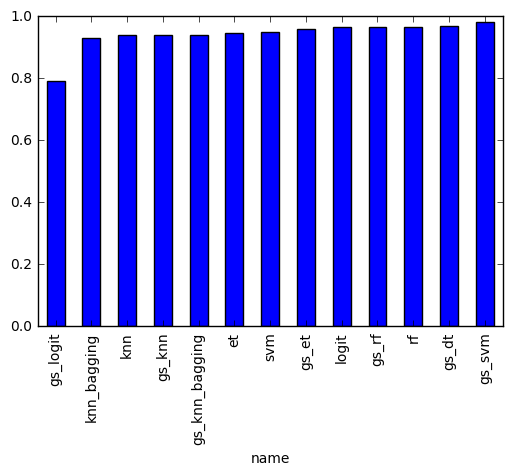

In [42]:
scores = []
names = []
models = []
for model in all_models:
    names.append(model)
    scores.append(all_models[model]['score'])
    models.append(all_models[model]['model'])

scores = pd.DataFrame(scores, columns = ['score'])
scores['name'] = names
new = scores.sort_values('score', ascending = True)
new.head()
new.plot(x='name', y = 'score', kind = 'bar', legend = False)

print "I am pretty sure I already did number 2."



In [40]:
from sklearn.model_selection import cross_val_score
means = []
stds = []

for m in models:
    temp = cross_val_score(m, X_train, y_train, cv = 3)
    means += [np.mean(temp)]
    stds += [np.std(temp)]

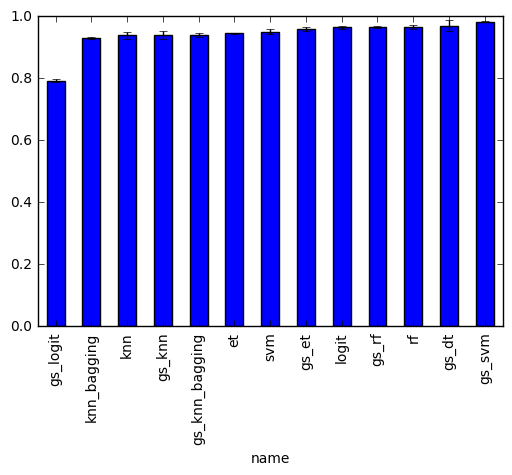

In [47]:
# get mean and std, y is mean
scores['mean'] = means
scores['stds'] = stds
scores = scores.sort_values('score', ascending = True)
scores.head()

scores.plot(x='name', y = 'score', kind = 'bar', yerr ='stds', legend = False)


## Bonus

We have encoded the data using a map that preserves the scale.
Would our results have changed if we had encoded the categorical data using `pd.get_dummies` or `OneHotEncoder`  to encode them as binary variables instead?

1. Repeat the analysis for this scenario. Is it better?
- Experiment with other models or other parameters, can you beat your classmates best score?